In [1]:
using Revise
using LowRankVortex
using TransportBasedInference
using LinearAlgebra
using Statistics
using PotentialFlow
import PotentialFlow.Plates: Plate, Points, Blobs
import PotentialFlow.Motions: reset_velocity!
import PotentialFlow.Elements
import PotentialFlow.Properties: @property
using JLD
using BenchmarkTools
using ProgressMeter
using Interpolations
using Distributions
using Permutations

In [2]:
using Plots
default(tickfont = font("CMU Serif", 18), 
        titlefont = font("CMU Serif", 18), 
        guidefont = font("CMU Serif", 18),
        legendfont = font("CMU Serif", 18),
        annotationfontsize = 18,
        annotationfontfamily = "CMU Serif",
        grid = false)
# clibrary(:colorbrewer)
pyplot()

using LaTeXStrings
PyPlot.rc("text", usetex = "true")
PyPlot.rc("font", family = "CMU Serif")
# gr()
using ColorSchemes

### Routines for the plots

In [24]:
function routine_plot(state, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    source = state_to_lagrange(state, config)
    plt = streamlines(X, Y, source, colorbar = false, 
                      xlim = (-2.2, 15), 
                      ylim = (-2.0, 2.0); levels = 10)
    if withvortices == true
        plot!(plt, source, markersize = 12, markerstrokealpha = 0, 
            color = cgrad(reverse(colormap("RdBu")[10:end-10])),
              clim = (-0.8, 0.8), legend = false)#label = ["Vortices" "Sources"], legend = :outerleft)
    end
    hline!(plt, [0.0], legend = false, color = :black)
    scatter!(plt, real.(sensors), imag.(sensors), color = :orangered2)#label = "Sensors", 
    plt
end

function routine_spectrum(Λ::Array{Float64,1})
    Λ = sort(abs.(Λ); rev = true)

    plt = plot(layout = grid(1,3), legend = false, margin = 5*Plots.px, size = (600, 300))

    scatter!(plt[1,1], collect(1:length(Λ)), Λ, 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i")
    scatter!(plt[1,2], collect(1:length(Λ)), cumsum(Λ)./sum(Λ),
           xlabel = L"i", ylabel = "Normalized cumulative energy")
    scatter!(plt[1,3], Λ[1:end-1] - Λ[2:end], 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
    return plt
end

function routine_plotCx(state, Cx::Matrix{Float64}, rx::Int64, config::VortexConfig, X::StepRangeLen, Y::StepRangeLen; withvortices::Bool=true)
    
    U, S, _ = svd(Symmetric(Cx))
    source = state_to_lagrange(state, config.zs, config)
    
    # Default julia colors
    cur_colors = theme_palette(:auto)
    
    nlines = rx ÷ 3 + 1
    if mod(rx, 3) == 0
        nlines -= 1
    end
    
    plt = plot(layout = grid(nlines, 3))
    
    for i = 1:rx
        idxlines = (i÷3) + 1
        idxcols  = i - 3*(i÷3) 
        if mod(i, 3) == 0
            idxlines -= 1
            idxcols = 3
        end
        
        if withvortices == true
            for j=1:config.Nv
                # Put circles to show strength change
                scatter!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1]],
                      [state[(j-1)*3+2]],
                      markersize = 50*abs.(U[3*j,i]), markerstrokecolor = cur_colors[i],
                      markeralpha = 1.0, 
                      markerstrokewidth = 3,
                      markercolor = :white, legend = false)
            end
#             plot!(plt[idxlines, idxcols], source, markersize = 12, markeralpha = 0.5, 
#                   color = cgrad(reverse(colormap("RdBu")[10:end-10])),
#                   clim = (-1.0, 1.0), label = ["Vortices" "Sources"], legend = false, colorbar = false)
            plot!(plt[idxlines, idxcols],  xlim = (-2.0, 2.0), xticks = -2.0:1.0:2.0, 
                  ylim = (0, 1.2*maximum(imag.(config.zs))))

            for j=1:config.Nv
                # Put arrows to indicate directions of change
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] - U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] - U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
                plot!(plt[idxlines, idxcols], 
                      [state[(j-1)*3+1], state[(j-1)*3+1] + U[(j-1)*3+1,i]],
                      [state[(j-1)*3+2], state[(j-1)*3+2] + U[(j-1)*3+2,i]], 
                      linewidth = 2, arrow=(:closed, 0.5), arrowsize = 0.5, color = cur_colors[i], legend = false)
            end
        end
    end
    plt
end

routine_plotCx (generic function with 1 method)

### Configuration setup

In [15]:
#
Δtgif = 0.1

# Pressure sensors
Δs = 0.5
sensors = complex.(-2.0:Δs:16.0)
Ny = length(sensors)

Nclusters = 5
# Standard deviation for the radial position of the vortices from the center of the clusters
σr = 0.1
zclusters = [-2.0 + 0.3*im; -1.9 + 1.9*im; -1.8 + 1.1*im; -1.3 + 1.4*im;
             -1.4 + 0.8*im; -1.5 + 1.7*im; -1.2 + 0.2*im]
Nset = 1

config_data = let Nv = Nclusters*Nset,
             U = complex(1.0), 
             ss = sensors, Δt = 1e-3, δ = 1e-1,
             ϵX = 1e-4, ϵΓ = 1e-4,
             β = 1.0,
             ϵY = 1e-2
    VortexConfig(Nv, U, ss, Δt, δ, ϵX, ϵΓ, β, ϵY)
end

Nv = config_data.Nv

xgrid = range(-3, 15, length=100)
ygrid = range(-2.2, 2.2, length=100)

t0 = 0.0
tf = 12.0
tspan = (t0, tf)

(0.0, 12.0)

### Generate the truth used in the twin experiment

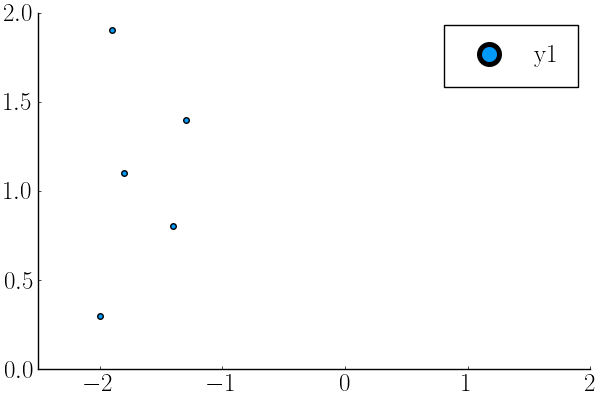

In [16]:
scatter(real.(zclusters)[1:Nclusters], imag.(zclusters)[1:Nclusters], xlims = (-2.5, 2.0), ylims = (0, 2.0))

In [19]:
freestream = Freestream(config_data.U)

Nv = Nclusters*Nset
zv = zeros(ComplexF64, Nv)

for i=1:Nclusters
    for j=1:Nset
#         @show (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)
        zv[(i-1)*Nset+j] = zclusters[i] + (σr/2 + σr/2*clamp(randn(), -3.0, 3.0)/3.0)*exp(im*2*π*rand())
    end
end

# zv =  rand(Nv) + 0.8*im*maximum(imag.(config_data.zs))*rand(Nv)
# zv .+= -2.0 + 0.1*im*maximum(imag.(config_data.zs))
Γv = zeros(Nv)
signclusters = [1; 1; 1; 1; 1; 1 ; 1]
Γvmean = [   0.09598711763757772;
             0.3942554457161529;
             0.66223264972610867;
             0.9718197621333651;
             0.7859171016908615;
             0.447930780784646;
             0.5103719570003264]
for i=1:Nclusters
    for j=1:Nset
        Γv[(i-1)*Nset+j] = signclusters[i]*abs.((0.4 + 0.1*randn()))
#         Γv[(i-1)*Nset+j] = signclusters[i]*abs.((Γvmean[i] + 0.1*randn()))
    end
#         Γv[i*Nset] = signclusters[i]*abs.(1.3 + 0.2*randn())
end
# Γv = abs.(randn(Nv))

blobs₊ = Nv >0 ? map(Vortex.Blob, zv, Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]
blobs₋ = Nv >0 ? map(Vortex.Blob, conj.(zv), -Γv, config_data.δ*ones(Nv)) : Vortex.Blob{Float64, Float64}[]

sys = vcat(blobs₊, blobs₋)

# data = generate_vortex(deepcopy(sys), t0, tf, config_data, "/media/mat/HDD/ToyVortex.jl/src/data/");
tt, x0, xt, yt = load("/media/mat/HDD/LowRankVortex.jl/example2/data/data_vortex.jld", "tt", "x0", "xt", "yt")
data = SyntheticData(tt, config_data.Δt, x0, xt, yt)

SyntheticData([0.0, 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009000000000000001  …  11.991, 11.992, 11.993, 11.994, 11.995000000000001, 11.996, 11.997, 11.998000000000001, 11.999, 12.0], 0.001, [-2.018587306805637, 0.3469573514039377, 0.45880001794294045, -1.8218225076346501, 1.8957320291019035, 0.3768744289098014, -1.8102180547912552, 1.0615219698346763, 0.26918155979815017, -1.273480600181778, 1.3996292681183138, 0.39099049767578464, -1.3586001809001103, 0.7834839950529129, 0.2327616928563841], [-2.018587306805637 -2.0172169502893196 … 12.59044061465947 12.591482987090947; 0.3469573514039377 0.3469042736866317 … 1.1421505993204804 1.1421716017979275; … ; 0.7834839950529129 0.7835958875071971 … 1.5055566951364918 1.5054079889283538; 0.2327616928563841 0.2327616928563841 … 0.2327616928563841 0.2327616928563841], [-0.524522656873511 -0.5090575008179341 … -0.4727590518054783 -0.4724508529842126; -0.5379397508961893 -0.5208171476572888 … -0.5119750022574816 -0.51414802719

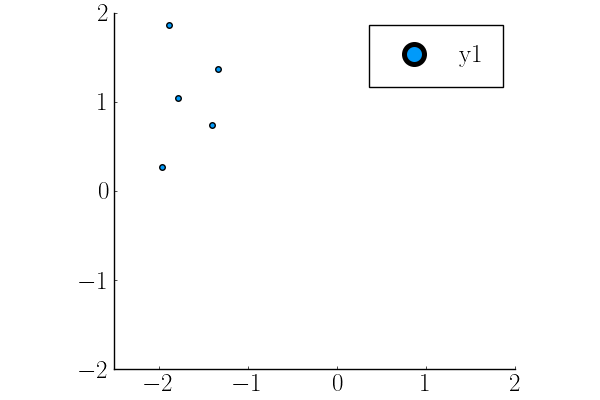

In [20]:
scatter(real.(zv), imag.(zv), xlims = (-2.5, 2.0), ylims = (-2.0, 2.0), ratio = 1.0)

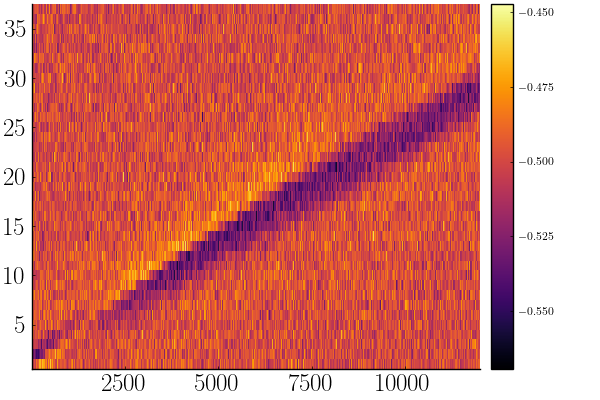

In [21]:
heatmap(data.yt)

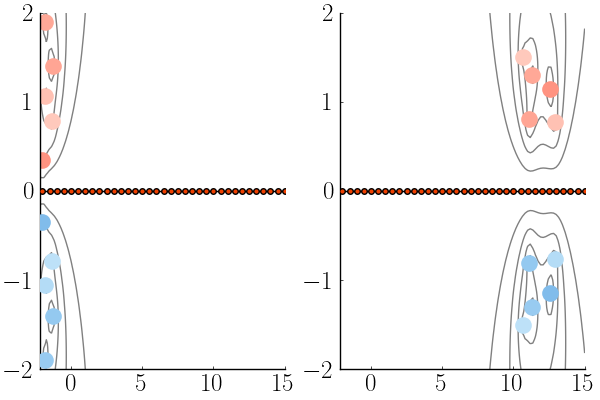

sys:1: UserWarning: The following kwargs were not used by contour: 'label'
sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [25]:
plt1 = routine_plot(data.xt[:,1], config_data, xgrid, ygrid; withvortices = true)
plt2 = routine_plot(data.xt[:,end], config_data, xgrid, ygrid; withvortices = true)

plot(plt1, plt2)

### Setup the sequential filter

In [26]:
# config = let Nv = Nclusters*Nset, Ns = 1, zs = [2.0*im], Qs = [1.0], U = complex(1.0), 
#              ss = sensors, Δt = 1e-2, δ = 1e-2,
#              ϵX = 5e-3, ϵΓ = 5e-3, ϵQ = 5e-3,
#              β = 1.0,
#              ϵY = 1e-2
#     VortexConfig(Nv, Ns, zs, Qs, U, ss, Δt, δ, ϵX, ϵΓ, ϵQ, β, ϵY)
# end

config = deepcopy(config_data)

VortexConfig(5, 1.0 + 0.0im, ComplexF64[-2.0 + 0.0im, -1.5 + 0.0im, -1.0 + 0.0im, -0.5 + 0.0im, 0.0 + 0.0im, 0.5 + 0.0im, 1.0 + 0.0im, 1.5 + 0.0im, 2.0 + 0.0im, 2.5 + 0.0im  …  11.5 + 0.0im, 12.0 + 0.0im, 12.5 + 0.0im, 13.0 + 0.0im, 13.5 + 0.0im, 14.0 + 0.0im, 14.5 + 0.0im, 15.0 + 0.0im, 15.5 + 0.0im, 16.0 + 0.0im], 0.001, 0.1, 0.0001, 0.0001, 1.0, 0.01)

In [27]:
# ϵX0 = 0.001
# ϵΓ0 = 0.001
# ϵQ0 = 0.001

# ϵ0 = RecipeInflation([ϵX0; ϵΓ0; ϵQ0])

ϵy = AdditiveInflation(Ny, zeros(Ny), config.ϵY)

AdditiveInflation(37, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

In [28]:
function spectrumCxCy(X, tsnap)
    Cx = zeros(Nx, Nx)
    Cy = zeros(Ny, Ny)


    nsnap = ceil(Int64, tsnap/0.1)+1

    Xcxcy = deepcopy(vcat(zeros(Ny, Ne), Xf[nsnap]))

    ϵX = config.ϵX
    ϵΓ = config.ϵΓ
    ϵQ = config.ϵQ
    β = config.β
    ϵY = config.ϵY

    ϵx = RecipeInflation([ϵX; ϵΓ; ϵQ])
    ϵmul = MultiplicativeInflation(β)

    # Perform state inflation
    ϵmul(Xcxcy, Ny+1, Ny+Nx)
    ϵx(Xcxcy, Ny, Nx, config)
    Dx = Diagonal(std(Xcxcy[Ny+1:end,:]; dims = 2)[:,1])
    # Dx = I
    Dϵ = config.ϵY*I
    freestream = Freestream(config.U)
    # Dϵ = I
    @inbounds for i=1:Ne

        J = analytical_jacobian_pressure(config.ss, state_to_lagrange(Xcxcy[Ny+1:end,i], config.zs, config), 
                                         freestream, tf; issourcefixed = true)
        Ji = J[:,vcat(collect(1:3*config.Nv), collect(6*config.Nv+1:6*config.Nv+config.Ns))]
        Cx .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)'*(inv(Dϵ)*Ji*Dx)
        Cy .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)*(inv(Dϵ)*Ji*Dx)'
    end
    
    Px, σx = svd(cov(Xcxcy[Ny+1:Ny+Nx,:]'))
    
    Vx, Λx = svd(Symmetric(Cx))
    Vy, Λy = svd(Symmetric(Cy))
    
    

    Λx = sort(abs.(Λx); rev = true)
    Λy = sort(abs.(Λy); rev = true)
    
    
    
    return Px, σx, Λx, Vx, Λy, Vy
end

spectrumCxCy (generic function with 1 method)

In [29]:
Ne = 1000

1000

In [30]:
# Xf = load("/media/mat/HDD/Paper Potential Flow/Example 2/ensemble_Ne_"*string(Ne)*".jld")["Xf"]

In [31]:
# save("/media/mat/HDD/Paper Potential Flow/Example 2/ensemble_reduced_Xf_EnKF_Ne_"*string(Ne)*".jld", "Xf", Xf[1:100:end])

Xf = load("/media/mat/HDD/LowRankVortex.jl/example2/ensemble_reduced_Xf_EnKF_Ne_"*string(Ne)*".jld")["Xf"];

In [29]:
Λxtab = Vector{Float64}[]
Λytab = Vector{Float64}[]

Nx = 3*config.Nv+ config.Ns

tlist = collect(0.0:0.1:12.0)

@showprogress for tsnap in tlist   
    nsnap = ceil(Int64, tsnap/0.1)+1
    Px, σx, Λx, Vx, Λy, Vy = spectrumCxCy(Xf[nsnap], tsnap)
    
    push!(Λxtab, deepcopy(Λx))
    push!(Λytab, deepcopy(Λy))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


In [30]:
q5_Λx = map(x-> quantile(x, 0.05), eachcol(hcat(Λxtab...)'))
q25_Λx = map(x-> quantile(x, 0.25), eachcol(hcat(Λxtab...)'))
q50_Λx = map(x-> quantile(x, 0.50), eachcol(hcat(Λxtab...)'))
q75_Λx = map(x-> quantile(x, 0.75), eachcol(hcat(Λxtab...)'))
q95_Λx = map(x-> quantile(x, 0.95), eachcol(hcat(Λxtab...)'))


q5_Ex  = map(x-> quantile(x, 0.05), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))
q25_Ex = map(x-> quantile(x, 0.25), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))
q50_Ex = map(x-> quantile(x, 0.50), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))
q75_Ex = map(x-> quantile(x, 0.75), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))
q95_Ex = map(x-> quantile(x, 0.95), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λxtab)...)'))


q5_deltaΛx = map(x-> quantile(x, 0.05), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))
q25_deltaΛx = map(x-> quantile(x, 0.25), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))
q50_deltaΛx = map(x-> quantile(x, 0.50), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))
q75_deltaΛx = map(x-> quantile(x, 0.75), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))
q95_deltaΛx = map(x-> quantile(x, 0.95), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λxtab)...)'))

q5_Λy = map(x-> quantile(x, 0.05), eachcol(hcat(Λytab...)'))
q25_Λy = map(x-> quantile(x, 0.25), eachcol(hcat(Λytab...)'))
q50_Λy = map(x-> quantile(x, 0.50), eachcol(hcat(Λytab...)'))
q75_Λy = map(x-> quantile(x, 0.75), eachcol(hcat(Λytab...)'))
q95_Λy = map(x-> quantile(x, 0.95), eachcol(hcat(Λytab...)'))


q5_Ey  = map(x-> quantile(x, 0.05), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))
q25_Ey = map(x-> quantile(x, 0.25), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))
q50_Ey = map(x-> quantile(x, 0.50), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))
q75_Ey = map(x-> quantile(x, 0.75), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))
q95_Ey = map(x-> quantile(x, 0.95), eachcol(hcat(map(y-> cumsum(y)./sum(y), Λytab)...)'))


q5_deltaΛy = map(x-> quantile(x, 0.05), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'))
q25_deltaΛy = map(x-> quantile(x, 0.25), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'))
q50_deltaΛy = map(x-> quantile(x, 0.50), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'))
q75_deltaΛy = map(x-> quantile(x, 0.75), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'))
q95_deltaΛy = map(x-> quantile(x, 0.95), eachcol(hcat(map(y-> y[1:end-1]-y[2:end], Λytab)...)'));

In [31]:
q50_Ex

15-element Vector{Float64}:
 0.8637939730959003
 0.9489268895070381
 0.9796861869049901
 0.9932904708563194
 0.997801075235735
 0.9993518693635527
 0.9998050123335303
 0.9999425534327592
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [33]:
q50_Ey

37-element Vector{Float64}:
 0.8638491591061304
 0.9516570214551608
 0.981887508344955
 0.994435478430593
 0.9987058366263633
 0.9997414796179804
 0.9999443655362016
 0.9999922295841518
 0.9999986281259786
 0.9999998157450842
 0.9999999858606711
 0.9999999985731945
 0.9999999998768193
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [86]:
Xxlist = [""; 2; ""; 4; ""; ""; ""; ""; "" ; 10]#; 150]
Xxliststring = string.(Xxlist)

10-element Vector{String}:
 ""
 "2"
 ""
 "4"
 ""
 ""
 ""
 ""
 ""
 "10"

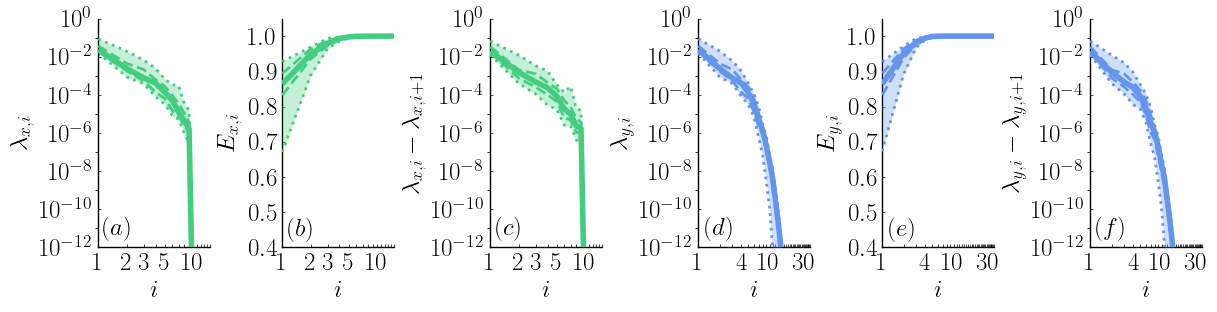

In [113]:
c_cx = colorant"tomato"
c_cx = colorant"seagreen3"
c_cy = colorant"cornflowerblue"

ylist = Float64[]
yliststring = String[]
for i=0:-2:-12
    push!(ylist, (10.0)^i)
    if mod(i, 2) == 0
        push!(yliststring, latexstring("10^{$i}"))
    else
        push!(yliststring, "")
    end
end


# Xxlist = Float64[]
# Xxliststring = String[]
# for i=0:-1:-10
#     push!(ylist, (10.0)^i)
#     if mod(i, 2) == 0
#         push!(Xxliststring, latexstring("10^{$i}"))
#     else
#         push!(Xliststring, "")
#     end
# end


Xxlist = Float64[]
Xxliststring = String[]
for i=1:Nx
    push!(Xxlist, i)
    if i ∈ [1;2;3;5; 10]
        push!(Xxliststring, latexstring("$i"))
    else
        push!(Xxliststring, "")
    end
end

Yxlist = Float64[]
Yxliststring = String[]
for i=1:Ny
    push!(Yxlist, i)
    if i ∈ [1; 4; 10; 30]
        push!(Yxliststring, latexstring("$i"))
    else
        push!(Yxliststring, "")
    end
end


# Yxlist = [10; 20; 30]
# Yxliststring = string.(Yxlist)


plt = plot(layout = grid(1,6), xlims = (1, Inf), legend = false, size = (1200, 300))


# Cx eigenvalues
plot!(plt[1,1], ylims = (10.0^(-12), 10.0^(-1)), yscale = :log10, xscale = :log10, yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda_{x, i}", xticks = (Xxlist, Xxliststring))


plot!(plt[1,1], 1:Nx, q5_Λx, linewidth = 2, linestyle = :dot, color = c_cx)
plot!(plt[1,1], 1:Nx, q25_Λx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,1], 1:Nx, q50_Λx, linewidth = 4, color = c_cx)
plot!(plt[1,1], 1:Nx, q75_Λx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,1], 1:Nx, q95_Λx, linewidth = 2, linestyle = :dot, color = c_cx)


plot!(plt[1,1], 1:Nx, [q50_Λx q50_Λx], linewidth = 0.0,
      fillrange = [q5_Λx q95_Λx], alpha = 0.3, color = c_cx,
      label = "") 

annotate!(plt[1,1], 1.6, 10.0^(-11), L"(a)")

# Cx cumulative energy
plot!(plt[1,2], xlabel = L"i", ylabel = L"E_{x, i}", ylim = (0.4, 1.05), xlims = (1, Inf),
     xticks = (Xxlist, Xxliststring), xscale = :log10)


plot!(plt[1,2], 1:Nx, q5_Ex, linewidth = 2, linestyle = :dot, color = c_cx)
plot!(plt[1,2], 1:Nx, q25_Ex, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,2], 1:Nx, q50_Ex, linewidth = 4, color = c_cx)
plot!(plt[1,2], 1:Nx, q75_Ex, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,2], 1:Nx, q95_Ex, linewidth = 2, linestyle = :dot, color = c_cx)

plot!(plt[1,2], 1:Nx, [q50_Ex q50_Ex], linewidth = 0.0,
      fillrange = [q5_Ex q95_Ex], alpha = 0.3, color = c_cx,
      label = "") 

annotate!(plt[1,2], 1.6, 0.45, L"(b)")


# Cx Spectral gap 
plot!(plt[1,3], ylims = (10.0^(-12), 10.0^(-1)), xscale = :log10, yscale = :log10, 
      yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda_{x, i} - \lambda_{x, i+1}", xticks = (Xxlist, Xxliststring))



plot!(plt[1,3], 1:Nx-1, q5_deltaΛx, linewidth = 2, linestyle = :dot, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q25_deltaΛx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q50_deltaΛx, linewidth = 4, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q75_deltaΛx, linewidth = 2, linestyle = :dash, color = c_cx)
plot!(plt[1,3], 1:Nx-1, q95_deltaΛx, linewidth = 2, linestyle = :dot, color = c_cx)

plot!(plt[1,3], 1:Nx-1, [q50_deltaΛx q50_deltaΛx], linewidth = 0.0,
      fillrange = [q5_deltaΛx q95_deltaΛx], alpha = 0.3, color = c_cx,
      label = "")

annotate!(plt[1,3], 1.6, 10.0^(-11), L"(c)")

# Cy eigenvalues
plot!(plt[1,4], ylims = (10.0^(-12), 10.0^(-1)), xscale = :log10, yscale = :log10, yticks = (ylist, yliststring),
              xlabel = L"i", ylabel = L"\lambda_{y, i}", xticks = (Yxlist, Yxliststring))


plot!(plt[1,4], 1:Ny, q5_Λy, linewidth = 2, linestyle = :dot, color = c_cy)
plot!(plt[1,4], 1:Ny, q25_Λy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,4], 1:Ny, q50_Λy, linewidth = 4, color = c_cy)
plot!(plt[1,4], 1:Ny, q75_Λy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,4], 1:Ny, q95_Λy, linewidth = 2, linestyle = :dot, color = c_cy)


plot!(plt[1,4], 1:Ny, [q50_Λy q50_Λy], linewidth = 0.0,
      fillrange = [q5_Λy q95_Λy], alpha = 0.3, color = c_cy,
      label = "") 


annotate!(plt[1,4], 2, 10.0^(-11), L"(d)")

# Cy cumulative energy
plot!(plt[1,5], xlabel = L"i", ylabel = L"E_{y, i}", xscale = :log10,
      ylim = (0.4, 1.05), xlims = (1, Inf), 
      xticks = (Yxlist, Yxliststring))


plot!(plt[1,5], 1:Ny, q5_Ey, linewidth = 2, linestyle = :dot, color = c_cy)
plot!(plt[1,5], 1:Ny, q25_Ey, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,5], 1:Ny, q50_Ey, linewidth = 4, color = c_cy)
plot!(plt[1,5], 1:Ny, q75_Ey, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,5], 1:Ny, q95_Ey, linewidth = 2, linestyle = :dot, color = c_cy)

plot!(plt[1,5], 1:Ny, [q50_Ey q50_Ey], linewidth = 0.0,
      fillrange = [q5_Ey q95_Ey], alpha = 0.3, color = c_cy,
      label = "") 

annotate!(plt[1,5], 2, 0.45, L"(e)")

# Cy Spectral gap 
plot!(plt[1,6], ylims = (10.0^(-12), 10.0^(-1)), xscale = :log10, yscale = :log10, yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda_{y, i} - \lambda_{y, i+1}", xticks = (Yxlist, Yxliststring))



plot!(plt[1,6], q5_deltaΛy, linewidth = 2, linestyle = :dot, color = c_cy)
plot!(plt[1,6], q25_deltaΛy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,6], q50_deltaΛy, linewidth = 4, color = c_cy)
plot!(plt[1,6], q75_deltaΛy, linewidth = 2, linestyle = :dash, color = c_cy)
plot!(plt[1,6], q95_deltaΛy, linewidth = 2, linestyle = :dot, color = c_cy)

plot!(plt[1,6], [q50_deltaΛy q50_deltaΛy], linewidth = 0.0,
      fillrange = [q5_deltaΛy q95_deltaΛy], alpha = 0.3, color = c_cy,
      label = "")

annotate!(plt[1,6], 2, 10.0^(-11), L"(f)")


savefig("example2_energy_spectrum.pdf")

In [15]:
Nx = 3*config.Nv+ config.Ns

15

In [16]:
Cx = zeros(Nx, Nx)
Cy = zeros(Ny, Ny)


tsnap = 1.0

nsnap = ceil(Int64, tsnap/config.Δt)+1

Xcxcy = deepcopy(vcat(zeros(Ny, Ne), Xf[nsnap]))
h(x, t) = measure_state(x, t, config)

ϵX = config.ϵX
ϵΓ = config.ϵΓ
ϵQ = config.ϵQ
β = config.β
ϵY = config.ϵY

ϵx = RecipeInflation([ϵX; ϵΓ; ϵQ])
ϵmul = MultiplicativeInflation(β)
ϵy = AdditiveInflation(zeros(Ny), ϵY)
# Perform state inflation
ϵmul(Xcxcy, Ny+1, Ny+Nx)
ϵx(Xcxcy, Ny, Nx, config)
Dx = Diagonal(std(Xcxcy[Ny+1:end,:]; dims = 2)[:,1])
# Dx = I
Dϵ = config.ϵY*I
# Dϵ = I
@time @inbounds for i=1:Ne
    observe(h, Xcxcy, tsnap, Ny, Nx)
#     ϵy(Xcxcy, 1, Ny)
    J = analytical_jacobian_pressure(config.ss, state_to_lagrange(Xcxcy[Ny+1:end,i], config.zs, config), 
                                     freestream, tf; issourcefixed = true)
    Ji = J[:,vcat(collect(1:3*config.Nv), collect(6*config.Nv+1:6*config.Nv+config.Ns))]
    Cx .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)'*(inv(Dϵ)*Ji*Dx)
    Cy .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)*(inv(Dϵ)*Ji*Dx)'
end

 50.037605 seconds (984.48 M allocations: 36.307 GiB, 15.82% gc time, 5.45% compilation time)


In [17]:
Σxx = cov(Xcxcy[Ny+1:Ny+Nx,:]')
Σyy = cov(Xcxcy[1:Ny,:]')
Σxy = 1/(Ne-1)*(Xcxcy[Ny+1:Ny+Nx,:] .- mean(Xcxcy[Ny+1:Ny+Nx,:]; dims = 2)[:,1])*(Xcxcy[1:Ny,:] .- mean(Xcxcy[1:Ny,:]; dims = 2)[:,1])';

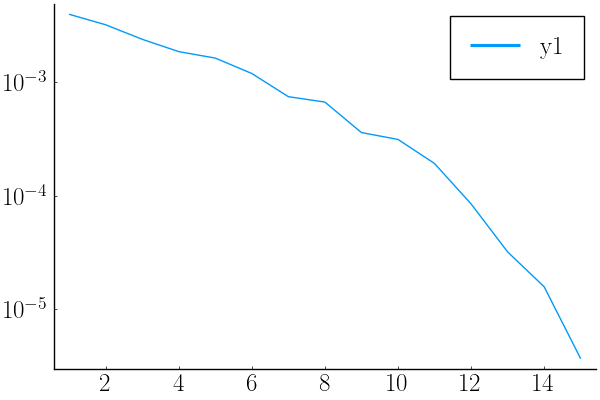

In [18]:
plot(svd(cov(Xcxcy[Ny+1:Ny+Nx,:]')).S, yscale = :log10)

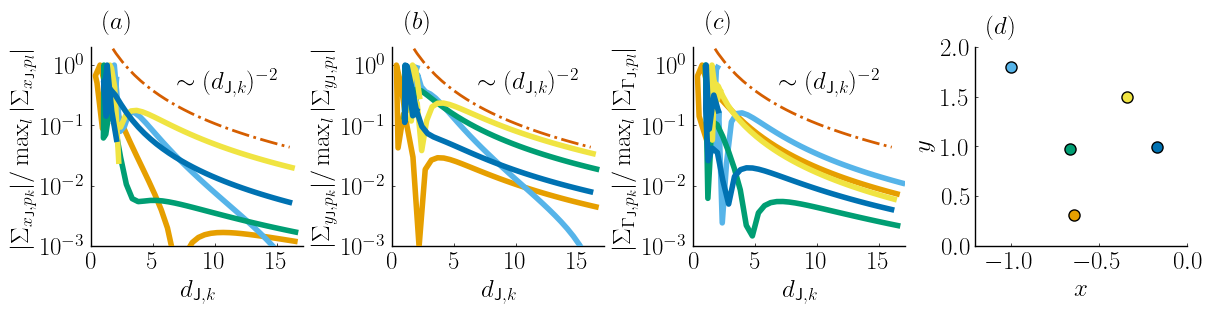

In [51]:
blobs = state_to_lagrange(mean(Xcxcy[Ny+1:Ny+Nx,:]; dims = 2)[:,1], config.zs, config)[1][1:config.Nv]

# c_Σxy = palette([palette(:viridis)[1], palette(:blackbody)[end], colorant"goldenrod3"], 15)
c_Σxy = palette(:okabe_ito)
c_σx = colorant"seagreen3"
c_σxy = colorant"tomato"
c_σy = colorant"cornflowerblue"

xlist = Float64[]
xliststring = String[]
for i=-2:1:2
    xi = tsnap+0.5*i
    push!(xlist, xi)
    push!(xliststring, latexstring("$xi"))
end

ylist = Float64[]
yliststring = String[]
for i=0:-1:-3
    push!(ylist, (10.0)^i)
    push!(yliststring, latexstring("10^{$i}"))
end

plt = plot(layout = grid(1,4), size = (1200, 300))

# ylabelstring = ["\widehat{\Sigma}_{x_i, y_i}"] 
for i=1:3
    plot!(plt[1,i], yticks = (ylist, yliststring), ylims = (10.0^(-3), 2*10.0^0), 
                    xlabel = L"d_{\mathsf{J}, k}", xlims = (0, Inf))
#           xlabel = string("Re")*L"(\xi_k)")
end
plot!(plt[1,1], ylabel = L"|\Sigma_{x_{\mathsf{J}},p_k}|/\max_l|\Sigma_{x_{\mathsf{J}},p_l}|")
plot!(plt[1,2], ylabel = L"|\Sigma_{y_{\mathsf{J}},p_k}|/\max_l|\Sigma_{y_{\mathsf{J}},p_l}|")
plot!(plt[1,3], ylabel = L"|\Sigma_{\Gamma_{\mathsf{J}},p_k}|/\max_l|\Sigma_{\Gamma_{\mathsf{J}},p_l}|")


plot!(plt[1,4], xlabel = L"x", ylabel = L"y",
    ylims = (0.0, 2.0), xlims = (-1.2, 0.0), xticks = tsnap-2:0.5:tsnap+1)

annotationlist = [L"(a)"; L"(b)"; L"(c)"; L"(d)"; L"(e)"; L"(f)"]
for i=1:3
    
    zc = sum(bi->abs(bi.S)*bi.z, blobs)/sum(bi->abs(bi.S), blobs) 
    vline!(plt[1,i], [real(zc)], linewidth = 2, linestyle = :dash, color = :grey47)
    plot!(plt[1,i], real.(sensors), 12 ./(abs.(sensors .- zc)).^2, 
          linestyle = :dashdot,linewidth = 2, color = c_Σxy[6])
    annotate!(plt[1,i], 2.2, 5.2, annotationlist[i], topmargin = 40*Plots.px)
    annotate!(plt[1,i], 11, 0.5, L"\tiny{\sim (d_{\mathsf{J}, k})^{-2}}")

end

annotate!(plt[1,4], -1.05, 2.2, annotationlist[4])


for (i, bi) in enumerate(blobs)
    dij = abs.(bi.z .- sensors)#.*sign.(real(sensors).-real(bi.z))
    
    plot!(plt[1,1], dij, abs.(Σxy[3*(i-1)+1,:])./maximum(abs.(Σxy[3*(i-1)+1,:])), 
          yscale = :log10, color = c_Σxy[i], linestyle = :solid, legend = false, linewidth = 4)
    plot!(plt[1,2], dij, abs.(Σxy[3*(i-1)+2,:])./maximum(abs.(Σxy[3*(i-1)+2,:])), 
          yscale = :log10, color = c_Σxy[i], linestyle = :solid, legend = false, linewidth = 4)
    plot!(plt[1,3], dij, abs.(Σxy[3*(i-1)+3,:])./maximum(abs.(Σxy[3*(i-1)+3,:])), 
          yscale = :log10, color = c_Σxy[i], linestyle = :solid, legend = false, linewidth = 4)
    
    scatter!(plt[1,4], [real(bi.z)], [imag(bi.z)], markersize = 8, color = c_Σxy[i], legend = false)
end

plt

savefig("cross_correlation.pdf")

In [44]:
function spectrumCxCy(X, tsnap)
    Cx = zeros(Nx, Nx)
    Cy = zeros(Ny, Ny)


    nsnap = ceil(Int64, tsnap/config.Δt)+1

    Xcxcy = deepcopy(vcat(zeros(Ny, Ne), Xf[nsnap]))

    ϵX = config.ϵX
    ϵΓ = config.ϵΓ
    ϵQ = config.ϵQ
    β = config.β
    ϵY = config.ϵY

    ϵx = RecipeInflation([ϵX; ϵΓ; ϵQ])
    ϵmul = MultiplicativeInflation(β)

    # Perform state inflation
    ϵmul(Xcxcy, Ny+1, Ny+Nx)
    ϵx(Xcxcy, Ny, Nx, config)
    Dx = Diagonal(std(Xcxcy[Ny+1:end,:]; dims = 2)[:,1])
    # Dx = I
    Dϵ = config.ϵY*I
    # Dϵ = I
    @time @inbounds for i=1:Ne

        J = analytical_jacobian_pressure(config.ss, state_to_lagrange(Xcxcy[Ny+1:end,i], config.zs, config), 
                                         freestream, tf; issourcefixed = true)
        Ji = J[:,vcat(collect(1:3*config.Nv), collect(6*config.Nv+1:6*config.Nv+config.Ns))]
        Cx .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)'*(inv(Dϵ)*Ji*Dx)
        Cy .+= 1/(Ne-1)*(inv(Dϵ)*Ji*Dx)*(inv(Dϵ)*Ji*Dx)'
    end
    
    Px, σx = svd(cov(Xcxcy[Ny+1:Ny+Nx,:]'))
    
    Vx, Λx = svd(Symmetric(Cx))
    Vy, Λy = svd(Symmetric(Cy))
    
    

    Λx = sort(abs.(Λx); rev = true)
    Λy = sort(abs.(Λy); rev = true)
    
    
    
    return Px, σx, Λx, Vx, Λy, Vy
end

spectrumCxCy (generic function with 1 method)

In [42]:
tsnap  = 10.0
Px, σx, Λx, Vx, Λy, Vy = spectrumCxCy(Xf, tsnap)

LoadError: BoundsError: attempt to access 121-element Vector{Matrix{Float64}} at index [10001]

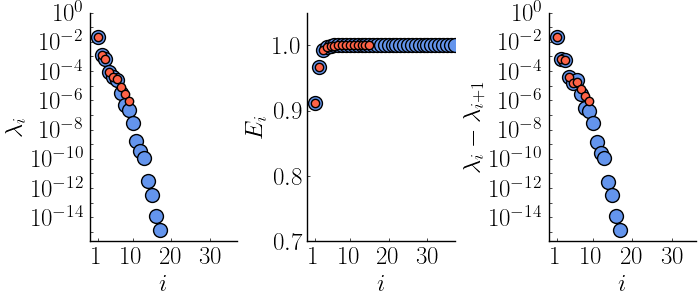

In [43]:
c_cx = colorant"tomato"
c_σx = colorant"seagreen3"
c_cy = colorant"cornflowerblue"

Λx = Λxtab[101]
Λy = Λytab[101]

ylist = Float64[]
yliststring = String[]
for i=0:-1:-15
    push!(ylist, (10.0)^i)
    if mod(i, 2) == 0
        push!(yliststring, latexstring("10^{$i}"))
    else
        push!(yliststring, "")
    end
end

xlist = [1; 10; 20; 30]
xliststring = string.(xlist)

plt = plot(layout = grid(1,3), legend = false, size = (700, 300), 
           xticks = (xlist, xliststring), xlim = (-1, Inf))# topmargin = 25*Plots.px)

# Decay of the energy spectrum
plot!(plt[1,1], ylims = (eps(), 1.0), yscale = :log10, yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda_i")#, rightmargin = 10Plots.px)
scatter!(plt[1,1], collect(1:length(Λy)), Λy, markersize = 10, color = c_cy)  
scatter!(plt[1,1], collect(1:length(Λx)), Λx, markersize = 6, color = c_cx)
# scatter!(plt[1,1], collect(1:length(σx)), σx, markersize = 6, color = c_σx)

# annotate!(plt[1,1], 5,12, text("(a)"))

# Cumulative energy spectrum
plot!(plt[1,2], xlabel = L"i", ylabel = L"E_i", ylim = (0.7, 1.05))#, rightmargin = 10Plots.px)
scatter!(plt[1,2], collect(1:length(Λy)), cumsum(Λy)./sum(Λy), markersize = 10, color = c_cy)
scatter!(plt[1,2], collect(1:length(Λx)), cumsum(Λx)./sum(Λx), markersize = 6, color = c_cx)

# annotate!(plt[1,1], 66, 12, text("(b)"))


plot!(plt[1,3], ylims = (eps(), 1.0), yscale = :log10, yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
scatter!(plt[1,3], Λy[1:end-1] - Λy[2:end], markersize = 10, color = c_cy)
scatter!(plt[1,3], Λx[1:end-1] - Λx[2:end], markersize = 6, color = c_cx)
# annotate!(plt[1,1], 129,12, text("(c)"))

# savefig("energy_spectrum_t"*string(ceil(Int64, 10*tsnap))*".pdf")

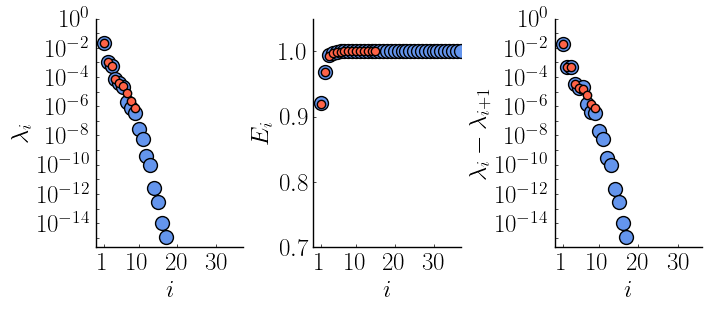

In [68]:
c_cx = colorant"tomato"
c_σx = colorant"seagreen3"
c_cy = colorant"cornflowerblue"


ylist = Float64[]
yliststring = String[]
for i=0:-1:-15
    push!(ylist, (10.0)^i)
    if mod(i, 2) == 0
        push!(yliststring, latexstring("10^{$i}"))
    else
        push!(yliststring, "")
    end
end

xlist = [1; 10; 20; 30]
xliststring = string.(xlist)

plt = plot(layout = grid(1,3), legend = false, size = (700, 300), 
           xticks = (xlist, xliststring), xlim = (-1, Inf))# topmargin = 25*Plots.px)

# Decay of the energy spectrum
plot!(plt[1,1], ylims = (eps(), 1.0), yscale = :log10, yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda_i")#, rightmargin = 10Plots.px)
scatter!(plt[1,1], collect(1:length(Λy)), Λy, markersize = 10, color = c_cy)  
scatter!(plt[1,1], collect(1:length(Λx)), Λx, markersize = 6, color = c_cx)
# scatter!(plt[1,1], collect(1:length(σx)), σx, markersize = 6, color = c_σx)

# annotate!(plt[1,1], 5,12, text("(a)"))

# Cumulative energy spectrum
plot!(plt[1,2], xlabel = L"i", ylabel = L"E_i", ylim = (0.7, 1.05))#, rightmargin = 10Plots.px)
scatter!(plt[1,2], collect(1:length(Λy)), cumsum(Λy)./sum(Λy), markersize = 10, color = c_cy)
scatter!(plt[1,2], collect(1:length(Λx)), cumsum(Λx)./sum(Λx), markersize = 6, color = c_cx)

# annotate!(plt[1,1], 66, 12, text("(b)"))


plot!(plt[1,3], ylims = (eps(), 1.0), yscale = :log10, yticks = (ylist, yliststring),
      xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
scatter!(plt[1,3], Λy[1:end-1] - Λy[2:end], markersize = 10, color = c_cy)
scatter!(plt[1,3], Λx[1:end-1] - Λx[2:end], markersize = 6, color = c_cx)
# annotate!(plt[1,1], 129,12, text("(c)"))

# savefig("energy_spectrum_t"*string(ceil(Int64, 10*tsnap))*".pdf")

In [25]:
cumsum(Λx)./sum(Λx)

15-element Vector{Float64}:
 0.7493110674605089
 0.925598805855141
 0.9590900264049402
 0.9846443795472396
 0.9925677437439341
 0.9968621678738003
 0.9994322102218581
 0.9998185838647448
 1.0
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002
 1.0000000000000002

In [26]:
cumsum(σx)./sum(σx)

15-element Vector{Float64}:
 0.25749506062030614
 0.4571309834337006
 0.5975894608284756
 0.6842371676407226
 0.7307057597315314
 0.7735032384870182
 0.8143413431254761
 0.8529509631407362
 0.8892495490292763
 0.9223743966128032
 0.9518207118376733
 0.9792639512074517
 0.992902011862702
 0.9986119573208456
 1.0

In [27]:
count(i-> i == false, convert(Vector{Bool}, cumsum(σx)./sum(σx) .> 0.999))+1

15

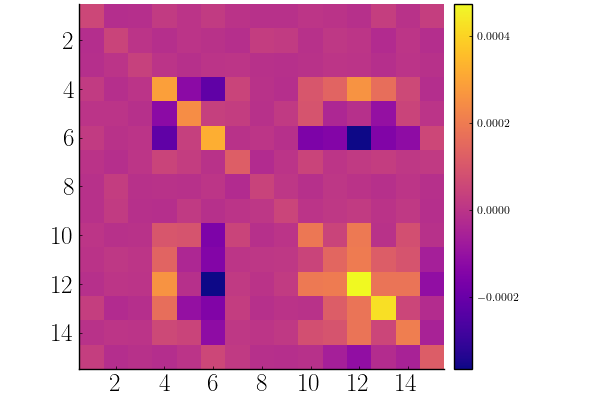

In [33]:
heatmap(((cov(Xcxcy[Ny+1:Ny+Nx,:]'))), yflip = true, ratio = 1.0, xlim = (-Inf, Inf),
            colorbar = true, color = :plasma, background_color_inside = palette(:plasma)[1])

In [28]:
count(i-> i == false, convert(Vector{Bool}, cumsum(Λx)./sum(Λx) .> 0.999))+1

7

In [29]:
count(i-> i == false, convert(Vector{Bool}, cumsum(Λy)./sum(Λy) .> 0.999))+1

4

In [30]:
color_palette

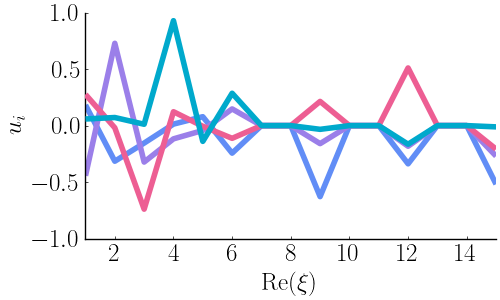

In [31]:
plt = plot(xlabel = string("Re")*L"(\xi)", ylabel = L"u_i", legend = false, size = (500, 300), 
           ylim = (-1.0, 1.0), xlim = (-Inf, Inf))
rlist = [1;2;3; 8]

clist = [theme_palette(:auto)[13]; theme_palette(:auto)[12];  theme_palette(:auto)[7];  theme_palette(:auto)[11]]
for (i,ri) in enumerate(rlist)
    plot!(plt, Vx[:,ri], color = clist[i],
          linestyle = :solid, linewidth = 4, legend = false)
end

plt
# savefig("V_eigenvectors_t_"*string(ceil(Int64, 10*tsnap))*".pdf")

  0.132730 seconds (440.98 k allocations: 157.074 MiB, 33.23% gc time)
  0.128147 seconds (440.98 k allocations: 157.074 MiB, 33.78% gc time)
  0.112055 seconds (440.98 k allocations: 157.074 MiB, 18.83% gc time)
  0.116738 seconds (440.98 k allocations: 157.074 MiB, 29.56% gc time)
  0.109262 seconds (440.98 k allocations: 157.074 MiB, 19.24% gc time)
  0.117490 seconds (440.98 k allocations: 157.074 MiB, 24.74% gc time)
  0.109809 seconds (440.98 k allocations: 157.074 MiB, 19.36% gc time)
  0.110889 seconds (440.98 k allocations: 157.074 MiB, 18.94% gc time)
  0.117120 seconds (440.98 k allocations: 157.074 MiB, 24.24% gc time)
  0.116600 seconds (440.98 k allocations: 157.074 MiB, 24.31% gc time)
  0.112120 seconds (440.98 k allocations: 157.074 MiB, 18.78% gc time)


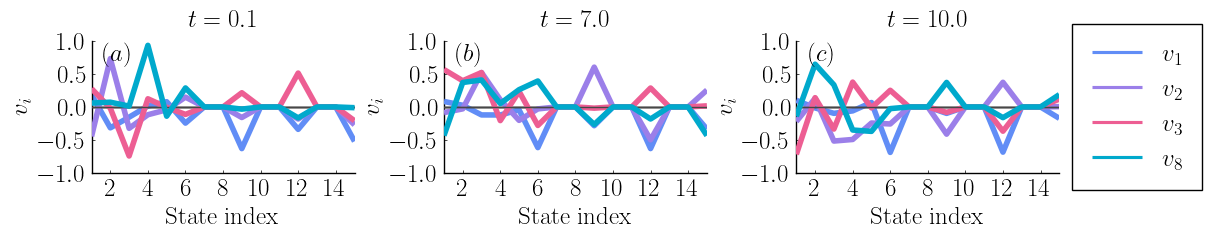

  0.117283 seconds (440.98 k allocations: 157.074 MiB, 24.37% gc time)


In [32]:
tsnaptab= [0.1; 7.0; 10.0]

plt = plot(layout = grid(1,3), xlabel = "State index", legend = false, ylabel = latexstring("v_{i}"),
           ylim = (-1.0, 1.0), xlim = (-Inf, Inf), size = (1200, 250), grid = false)

indexlist = ["(a)"; "(b)"; "(c)"]#; "(d)"; "(e)"; "(f)"; "(g)"; "(h)"; "(i)"; "(j)"; "(k)"; "(l)"]
rlist = [1;2;3;8]
counter = 1
signflip = [1 1 1; 1 -1 -1; 1  1 -1; 1 -1 1]
for (j,rj) in enumerate(rlist)
    for (i, ti) in enumerate(tsnaptab) 
        _, _, _, Vx, _, _  =spectrumCxCy(Xf, ti)
        ni = ceil(Int64, ti/config.Δt)+1
        blobs, _ = state_to_lagrange(mean(Xf[ni]; dims = 2)[:,1], config.zs, config)
        zci = sum(bi->abs(bi.S)*bi.z, blobs)/sum(bi->abs(bi.S), blobs) 
        hline!(plt[1,i], [0.0], linewidth = 1, color = :grey28, linestyle = :solid, label = "")
        if i == length(tsnaptab)
            plot!(plt[1,i], signflip[j,i]*Vx[:,rj], color = clist[j],
            linestyle = :solid, linewidth = 4, legend = :outerright, label = latexstring("v_{$rj}"),
            topmargin = 30*Plots.px) 
        else
            plot!(plt[1,i], signflip[j,i]*Vx[:,rj], color = clist[j],
            linestyle = :solid, linewidth = 4, legend = false, label = "",
            topmargin = 30*Plots.px)    
        end

    end
end
for (i, ti) in enumerate(tsnaptab) 
    annotate!(plt[1,i], 8.0, 1.3, latexstring("t = $ti"), topmargin = 50*Plots.px)
    annotate!(plt[1,i], 2.4, 0.8, latexstring(indexlist[i]))
end
plt

savefig("V_eigenvector.pdf")



In [151]:
clist

  0.123301 seconds (440.98 k allocations: 157.074 MiB, 30.32% gc time)
  0.125718 seconds (440.98 k allocations: 157.074 MiB, 32.84% gc time)
  0.129110 seconds (440.98 k allocations: 157.074 MiB, 16.16% gc time)
  0.151256 seconds (440.98 k allocations: 157.074 MiB, 22.73% gc time)
  0.151493 seconds (440.98 k allocations: 157.074 MiB, 21.08% gc time)
  0.144641 seconds (440.98 k allocations: 157.074 MiB, 17.56% gc time)
  0.127267 seconds (440.98 k allocations: 157.074 MiB, 26.18% gc time)
  0.115444 seconds (440.98 k allocations: 157.074 MiB, 24.37% gc time)
  0.133323 seconds (440.98 k allocations: 157.074 MiB, 18.79% gc time)
  0.149624 seconds (440.98 k allocations: 157.074 MiB, 23.83% gc time)
  0.152204 seconds (440.98 k allocations: 157.074 MiB, 21.23% gc time)


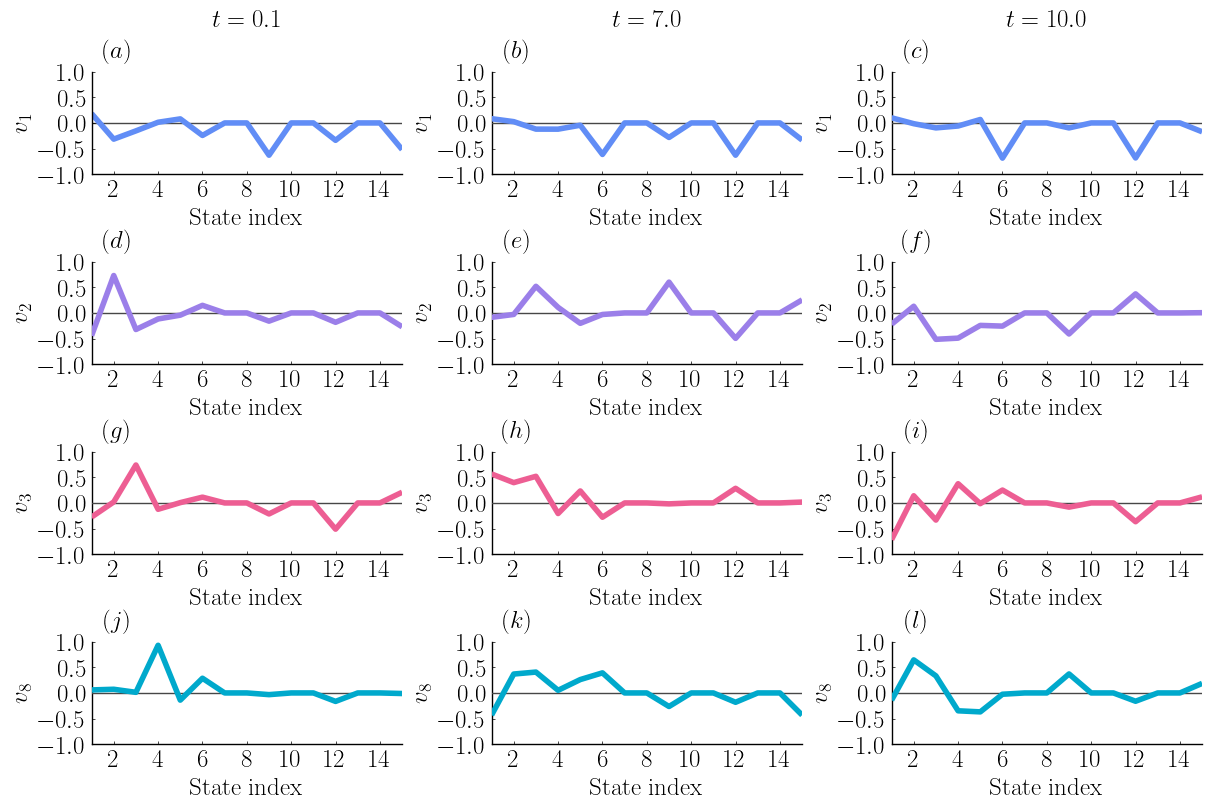

  0.145981 seconds (440.98 k allocations: 157.074 MiB, 17.96% gc time)


In [33]:
tsnaptab= [0.1; 7.0; 10.0]

plt = plot(layout = grid(4,3), xlabel = "State index", legend = false, 
           ylim = (-1.0, 1.0), xlim = (-Inf, Inf), size = (1200, 800), grid = false)

indexlist = ["(a)"; "(b)"; "(c)"; "(d)"; "(e)"; "(f)"; "(g)"; "(h)"; "(i)"; "(j)"; "(k)"; "(l)"]
rlist = [1;2;3; 8]
counter = 0
signflip = [1 1 1; 1 -1 -1; 1  1 -1; 1 -1 1]
for (j,rj) in enumerate(rlist)
    for (i, ti) in enumerate(tsnaptab) 
        _, _, _, Vx, _, _  =spectrumCxCy(Xf, ti)
        ni = ceil(Int64, ti/config.Δt)+1
        blobs, _ = state_to_lagrange(mean(Xf[ni]; dims = 2)[:,1], config.zs, config)
        zci = sum(bi->abs(bi.S)*bi.z, blobs)/sum(bi->abs(bi.S), blobs) 
        counter += 1
        hline!(plt[j,i], [0.0], linewidth = 1, color = :grey28, linestyle = :solid)
        plot!(plt[j,i], signflip[j,i]*Vx[:,rj], color = clist[j],
              linestyle = :solid, linewidth = 4, legend = false, ylabel = latexstring("v_{$rj}"), 
              topmargin = 20*Plots.px) 
        annotate!(plt[j,i], 2.2, 1.4, latexstring(indexlist[counter]))
    end
end
for (i, ti) in enumerate(tsnaptab) 
    annotate!(plt[1,i], 8.0, 2.0, latexstring("t = $ti"), topmargin = 60*Plots.px)
end
plt
savefig("V_eigenvector.pdf")

  0.124477 seconds (440.99 k allocations: 157.074 MiB, 28.36% gc time)
  0.120961 seconds (440.98 k allocations: 157.074 MiB, 31.11% gc time)
  0.151089 seconds (440.98 k allocations: 157.074 MiB, 20.74% gc time)
  0.144483 seconds (440.98 k allocations: 157.074 MiB, 16.90% gc time)
  0.151120 seconds (440.98 k allocations: 157.074 MiB, 21.75% gc time)
  0.151374 seconds (440.98 k allocations: 157.074 MiB, 20.71% gc time)
  0.147485 seconds (440.98 k allocations: 157.074 MiB, 17.79% gc time)
  0.149321 seconds (440.98 k allocations: 157.074 MiB, 22.32% gc time)
  0.151855 seconds (440.98 k allocations: 157.074 MiB, 21.34% gc time)
  0.144041 seconds (440.98 k allocations: 157.074 MiB, 17.14% gc time)
  0.138954 seconds (440.98 k allocations: 157.074 MiB, 17.73% gc time)


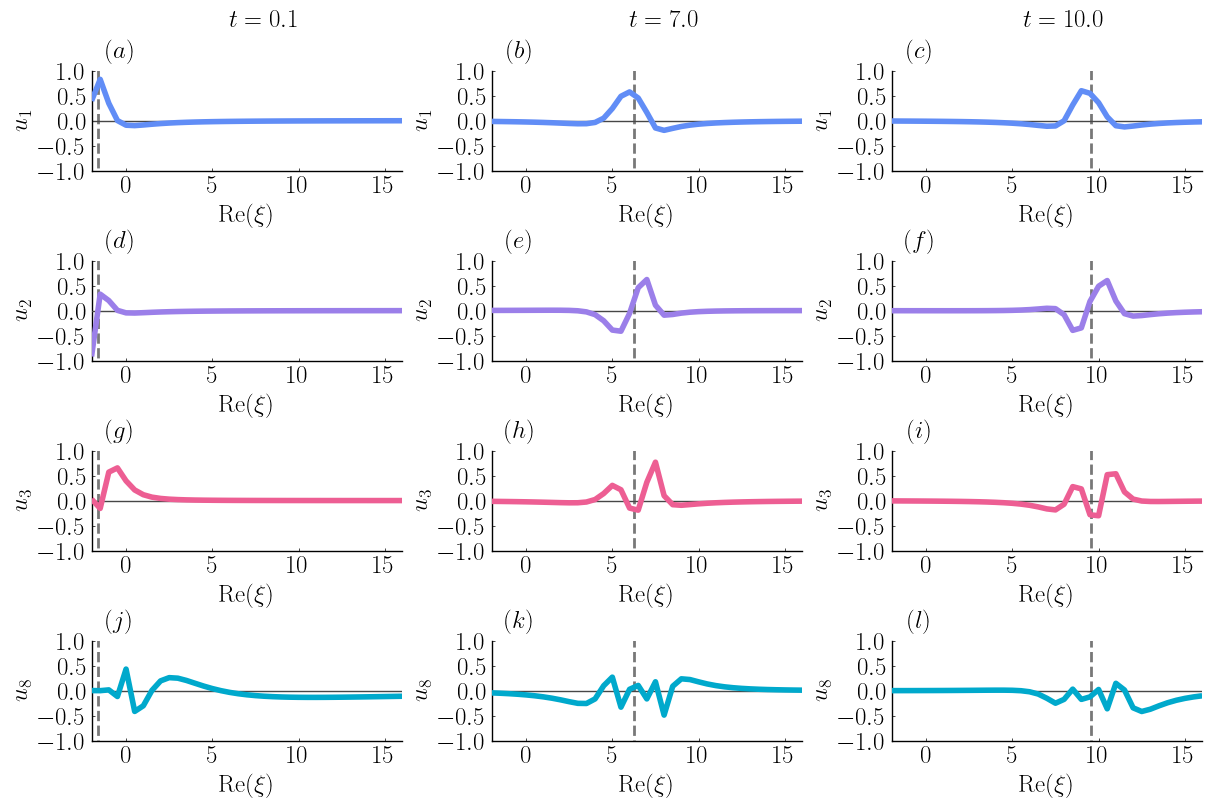

  0.153648 seconds (440.98 k allocations: 157.074 MiB, 20.78% gc time)


In [37]:
tsnaptab= [0.1; 7.0; 10.0]

plt = plot(layout = grid(4,3), xlabel = string("Re")*L"(\xi)", legend = false, 
           ylim = (-1.0, 1.0), xlim = (-Inf, Inf), size = (1200, 800), grid = false)

indexlist = ["(a)"; "(b)"; "(c)"; "(d)"; "(e)"; "(f)"; "(g)"; "(h)"; "(i)"; "(j)"; "(k)"; "(l)"]
rlist = [1;2;3; 8]
counter = 0
signflip = [1 1 1; 1 -1 1; 1  1 1; 1 -1 1]
for (j,rj) in enumerate(rlist)
    for (i, ti) in enumerate(tsnaptab) 
        _, _, _, _, _, Vy  =spectrumCxCy(Xf, ti)
        ni = ceil(Int64, ti/config.Δt)+1
        blobs, _ = state_to_lagrange(mean(Xf[ni]; dims = 2)[:,1], config.zs, config)
        zci = sum(bi->abs(bi.S)*bi.z, blobs)/sum(bi->abs(bi.S), blobs) 
        counter += 1
        vline!(plt[j,i], [real(zci)], linewidth = 2, linestyle = :dash, color = :grey47)
        hline!(plt[j,i], [0.0], linewidth = 1, color = :grey28, linestyle = :solid)
        plot!(plt[j,i], real(sensors), signflip[j,i]*Vy[:,rj], color = clist[j],
              linestyle = :solid, linewidth = 4, legend = false, ylabel = latexstring("u_{$rj}"), 
              topmargin = 20*Plots.px) 
        annotate!(plt[j,i], -0.3, 1.4, latexstring(indexlist[counter]))
    end
end
for (i, ti) in enumerate(tsnaptab) 
    annotate!(plt[1,i], 8.0, 2.0, latexstring("t = $ti"), topmargin = 60*Plots.px)
end
plt
savefig("U_eigenvector.pdf")

In [340]:
Vy[:,1]

37-element Vector{Float64}:
 -0.008628491072351148
 -0.009423505060514013
 -0.010332564391132735
 -0.011378297634389845
 -0.012589145981089563
 -0.014001212144304272
 -0.015660811996290266
 -0.01762803669131338
 -0.019981780372142623
 -0.022826904240668675
 -0.026304507219641414
 -0.030606630900988297
 -0.03599693853314018
  ⋮
  0.08449519817235777
 -0.10370634429566696
 -0.12902072655966393
 -0.11100312865085006
 -0.08926825092433618
 -0.07139144415026483
 -0.05770704565550332
 -0.047326331070112804
 -0.0393807318573623
 -0.03321168725601958
 -0.028348447801250565
 -0.024457932864793624

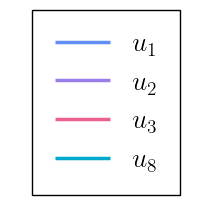

In [38]:
plt = plot(xlim = (0.1, 0.2), ylim = (0.0, 0.1), xaxis = false, yaxis = false, legend = :bottom, 
           size = (200, 200), legendfont = font("CMU Serif", 20))

for (i, ri) in enumerate(rlist)
    plot!(plt, zeros(2), linewidth = 3, label = label = latexstring("u_{$ri}"), color = clist[i])
end
plt

savefig("legend_U_eigenvector.pdf")

In [263]:
function routine_spectrum(Λ::Array{Float64,1})
    Λ = sort(abs.(Λ); rev = true)

    plt = plot(layout = grid(1,3), legend = false, margin = 5*Plots.px, size = (600, 300))

    scatter!(plt[1,1], collect(1:length(Λ)), Λ, 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i")
    scatter!(plt[1,2], collect(1:length(Λ)), cumsum(Λ)./sum(Λ),
           xlabel = L"i", ylabel = "Normalized cumulative energy")
    scatter!(plt[1,3], Λ[1:end-1] - Λ[2:end], 
          yscale = :log10, xlabel = L"i", ylabel = L"\lambda_i - \lambda_{i+1}")
    return plt
end

routine_spectrum (generic function with 1 method)

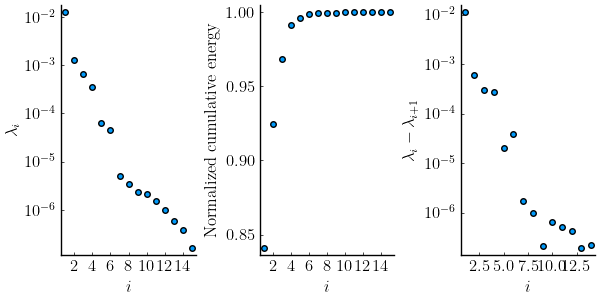

In [171]:
routine_spectrum(svd(Symmetric(Cx)).S)

In [22]:
routine_spectrum(svd(Symmetric(Cy)).S)

PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/mat/.julia/packages/PyCall/BD546/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError('Axis limits cannot be NaN or Inf')
  File "/home/mat/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 3849, in set_ylim
    top = self._validate_converted_limits(top, self.convert_yunits)
  File "/home/mat/.julia/conda/3/lib/python3.9/site-packages/matplotlib/axes/_base.py", line 3439, in _validate_converted_limits
    raise ValueError("Axis limits cannot be NaN or Inf")


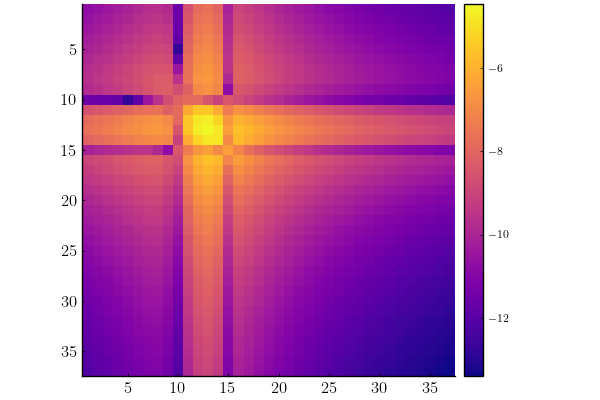

In [23]:
heatmap(log.(abs.(Cy)), yflip = true, ratio = 1.0, xlim = (-Inf, Inf),
            colorbar = true, color = :plasma, background_color_inside = palette(:plasma)[1])

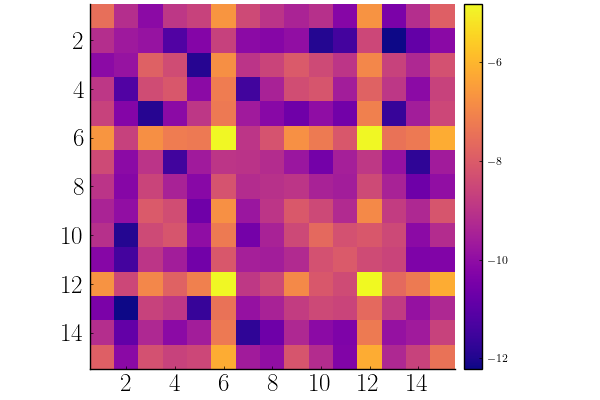

In [159]:
heatmap(1:Nx, 1:Nx, log.(abs.(Cx)), yflip = true, ratio = 1.0, xlim = (-Inf, Inf),
            colorbar = true, color = :plasma, background_color_inside = palette(:plasma)[1])

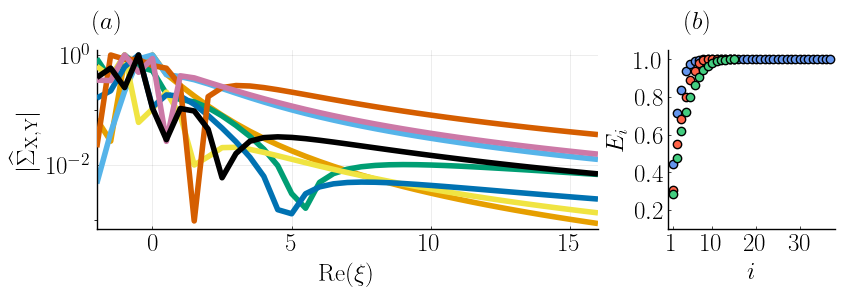

In [585]:
# # c_Σxy =  palette([palette(:viridis)[1], palette(:blackbody)[end], colorant"seagreen3"], 15)
# c_Σxy = palette([palette(:viridis)[1], palette(:blackbody)[end], colorant"goldenrod3"], 15)
# c_Σxy = palette(:okabe_ito)
# c_σx = colorant"seagreen3"
# c_σxy = colorant"tomato"
# c_σy = colorant"cornflowerblue"

# ylist = Float64[]
# yliststring = String[]

# perm = [1;15;7;2;11;6;3;8;13;5;12;4;9;10;14]#RandomPermutation(15).data
# for i=-4:-1:-9
#     push!(ylist, (10.0)^i)
#     if mod(i, 2) == 0
#         push!(yliststring, latexstring("10^{$i}"))
#     else
#         push!(yliststring, "")
#     end
# end

# xlist = [1; 10; 20; 30]
# xliststring = string.(xlist)

# l = @layout [a{0.6w} b{0.2w}]
# plt = plot(layout = l, size = (1000, 300))

# plot!(plt[1,1], xlim =(-Inf, Inf),#, yticks = (ylist, yliststring), ylims = (10.0^(-9), 10.0^(-4)),
#            xlabel = string("Re")*L"(\xi)", ylabel = L"|\widehat{\Sigma}_{\mathrm{X},\mathrm{Y}}|", grid = true)
# counter = 0
# for i=1:2:15
#     counter += 1
#     plot!(plt[1,1], real.(sensors), (abs.(Σxy[i,:]))./ maximum(abs.(Σxy[i,:])), yscale = :log10, color = c_Σxy[counter], linestyle = :solid, legend = false, linewidth = 4)
# end

# plot!(plt[1,2], ylims = (0.1, 1.05), xlabel = L"i", ylabel = L"E_i", xticks = (xlist, xliststring))

# scatter!(plt[1,2], cumsum(svd(Σyy).S)./sum(svd(Σyy).S), markersize = 6, color = c_σy, legend = false)
# scatter!(plt[1,2], cumsum(svd(Σxy).S)./sum(svd(Σxy).S), markersize = 6, color = c_σxy, legend = false)
# scatter!(plt[1,2], cumsum(svd(Σxx).S)./sum(svd(Σxx).S), markersize = 6, color = c_σx, legend = false)
# annotate!(plt[1,2], -128, 1.2, L"(a)",  topmargin = 60*Plots.px)
# annotate!(plt[1,2], 7, 1.2, L"(b)",  topmargin = 60*Plots.px)


# savefig("cross_correlation.pdf")